In [1]:
%matplotlib inline  
import struct
from struct import unpack
from numpy import zeros, uint8, float32
from pylab import imshow, show, cm
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

#Initialize for keras
import keras
from keras.datasets import mnist
from keras.models import Sequential, Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras import backend as K

Using TensorFlow backend.


In [2]:
# Define functions for reading data.
# Based on https://gist.github.com/tylerneylon/
def read_idx(filename):
    """
        Read from file and create numpy array
    """
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)

def get_data(image_file, label_file, num_classes = 10):
    """
        Read the image and label data
    """
    # Read the files
    pre_images = read_idx(image_file)
    pre_labels = read_idx(label_file)
    
    images = np.zeros((len(pre_images), 28,28, 1), dtype=np.float32)
    labels = np.zeros((len(pre_labels),num_classes), dtype=np.int8)
    for i in range(len(pre_images)):
        pre_img=pre_images[i]
        pre_label=pre_labels[i]
        img = (pre_img.transpose() / 255.0)
        images[i] = img.reshape(28,28,1) 
        labels[i] = keras.utils.to_categorical(pre_label, num_classes)
    
    return images, labels


In [3]:
num_classes = 10

train_image_file = '/home/carnd/data/emnist/emnist-digits-train-images-idx3-ubyte'
train_label_file = '/home/carnd/data/emnist/emnist-digits-train-labels-idx1-ubyte'
train_images, train_labels = get_data(train_image_file, train_label_file,num_classes)
print ('Training Data')
print ('Images Shape: {}'.format(train_images.shape))
print ('Labels Shape: {}'.format(train_labels.shape))

test_image_file = '/home/carnd/data/emnist/emnist-digits-test-images-idx3-ubyte'
test_label_file = '/home/carnd/data/emnist/emnist-digits-test-labels-idx1-ubyte'
test_images, test_labels = get_data(test_image_file, test_label_file,num_classes)
print ('Training Data')
print ('Images Shape: {}'.format(test_images.shape))
print ('Labels Shape: {}'.format(test_labels.shape))

Training Data
Images Shape: (240000, 28, 28, 1)
Labels Shape: (240000, 10)
Training Data
Images Shape: (40000, 28, 28, 1)
Labels Shape: (40000, 10)


Label - 8 : [0 0 0 0 0 0 0 0 1 0] 


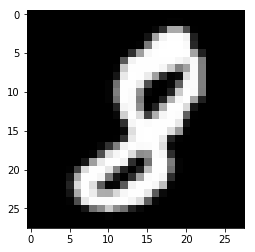

Label - 9 : [0 0 0 0 0 0 0 0 0 1] 


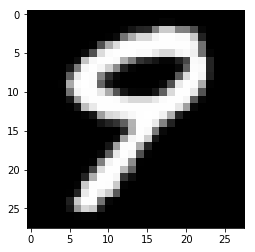

In [4]:
def view_image(image, label=""):
    """View a single image."""
    print("Label - {} : {} ".format(np.argmax(label), label))
    plt.imshow((image.reshape(28,28)), cmap="gray")
    plt.show()

for i in range(2):
    view_image(train_images[i], train_labels[i])

In [5]:
# Train, Test split
from sklearn.model_selection import train_test_split
X_val, X_test, y_val, y_test = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

In [6]:
# Initialize the hyperparameters
input_shape = (28,28, 1)

In [ ]:
# Build model
inputs = Input(shape=input_shape)

tower_1 = Conv2D(16, (3, 3), strides=(1, 1), padding='same', name = "inc1_conv1", activation='relu')(inputs)
tower_2 = Conv2D(16, (5, 5), strides=(1, 1), padding='same', name = "inc1_conv2", activation='relu')(inputs)
tower_3 = Conv2D(16, (7, 7), strides=(1, 1), padding='same', name = "inc1_conv3", activation='relu')(inputs)
tower_4 = Conv2D(16, (9, 9), strides=(1, 1), padding='same', name = "inc1_conv4", activation='relu')(inputs)
concat_1 = keras.layers.concatenate([tower_1, tower_2, tower_3, tower_4], axis=3, name = "inc1_concat")

reduce = Conv2D(16, (1, 1), strides=(1, 1), padding='same', name = "inc2_1by1_1")(concat_1)
tower_1 = Conv2D(32, (3, 3), strides=(1, 1), padding='same', name = "inc2_conv1", activation='relu')(reduce)

tower_2 = Conv2D(32, (5, 5), strides=(1, 1), padding='same', name = "inc2_conv2", activation='relu')(reduce)

tower_3 = Conv2D(32, (7, 7), strides=(1, 1), padding='same', name = "inc2_conv3", activation='relu')(reduce)

tower_4 = Conv2D(32, (9, 9), strides=(1, 1), padding='same', name = "inc2_conv4", activation='relu')(reduce)

concat_2 = keras.layers.concatenate([tower_1, tower_2, tower_3, tower_4], axis=3, name = "inc2_concat")
concat_2 = Conv2D(16, (1, 1), strides=(1, 1), padding='same', activation='relu', name = "conc_1x1_1")(concat_2)

flat = Flatten()(concat_2)
dense = Dense(128, activation='relu', name = "dense1")(flat)
dropout = Dropout(0.4)(dense)
outputs = Dense(num_classes, activation='softmax', name = "output")(dropout)

model = Model(inputs=inputs, outputs=outputs)

model.summary()
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Nadam(),
              metrics=['accuracy'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
inc1_conv1 (Conv2D)              (None, 28, 28, 16)    160         input_1[0][0]                    
____________________________________________________________________________________________________
inc1_conv2 (Conv2D)              (None, 28, 28, 16)    416         input_1[0][0]                    
____________________________________________________________________________________________________
inc1_conv3 (Conv2D)              (None, 28, 28, 16)    800         input_1[0][0]                    
___________________________________________________________________________________________

In [ ]:
batch_size = 250
epochs = 50
history = model.fit(train_images, train_labels,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(X_val, y_val))

Train on 240000 samples, validate on 20000 samples
Epoch 1/50
267s - loss: 0.0811 - acc: 0.9762 - val_loss: 0.0221 - val_acc: 0.9935
Epoch 2/50
264s - loss: 0.0332 - acc: 0.9910 - val_loss: 0.0168 - val_acc: 0.9954
Epoch 3/50
264s - loss: 0.0260 - acc: 0.9926 - val_loss: 0.0190 - val_acc: 0.9947
Epoch 4/50
264s - loss: 0.0222 - acc: 0.9939 - val_loss: 0.0170 - val_acc: 0.9950
Epoch 5/50
264s - loss: 0.0198 - acc: 0.9944 - val_loss: 0.0200 - val_acc: 0.9946
Epoch 6/50
264s - loss: 0.0182 - acc: 0.9950 - val_loss: 0.0186 - val_acc: 0.9952
Epoch 7/50
264s - loss: 0.0163 - acc: 0.9954 - val_loss: 0.0207 - val_acc: 0.9950
Epoch 8/50
264s - loss: 0.0151 - acc: 0.9957 - val_loss: 0.0210 - val_acc: 0.9954
Epoch 9/50
264s - loss: 0.0140 - acc: 0.9959 - val_loss: 0.0186 - val_acc: 0.9953
Epoch 10/50
264s - loss: 0.0132 - acc: 0.9962 - val_loss: 0.0223 - val_acc: 0.9950
Epoch 11/50
264s - loss: 0.0122 - acc: 0.9965 - val_loss: 0.0179 - val_acc: 0.9956
Epoch 12/50
264s - loss: 0.0110 - acc: 0.9968

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1, batch_size=batch_size)
print('Test loss:', score[0])
print('Test accuracy:', score[1])